Enter the amount you want to invest right now (in USD$$) : 200000


[*********************100%***********************]  5 of 5 completed
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


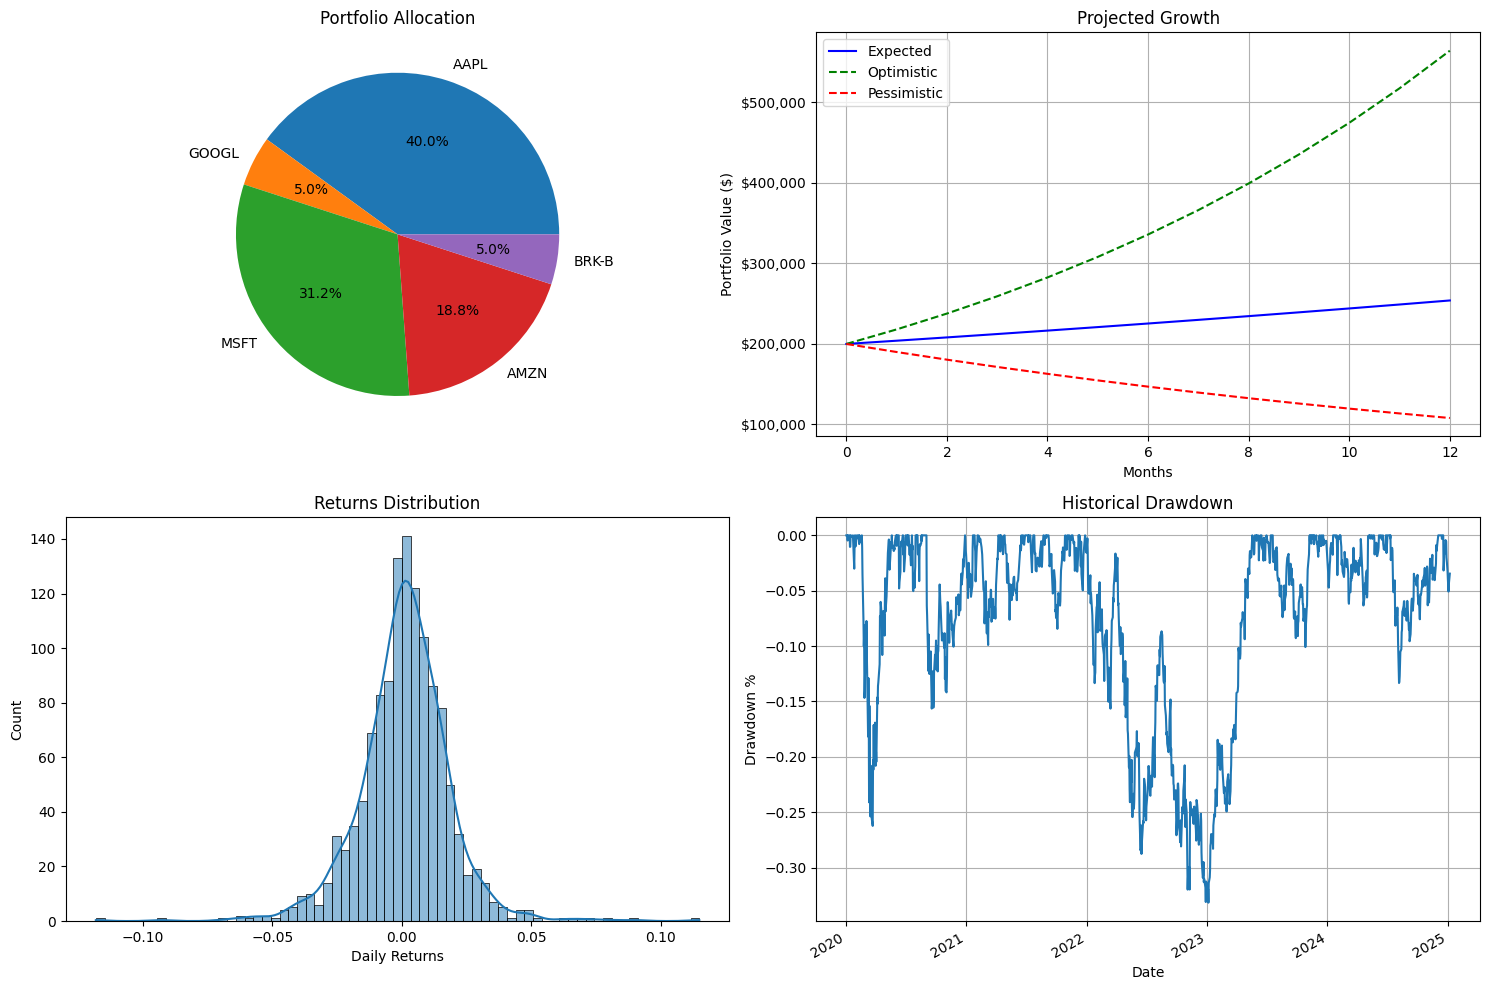


Portfolio Analysis Summary
Initial Investment: $200,000.00
Expected Annual Return: 24.1%
Annual Volatility: 24.3%
Sharpe Ratio: 0.99
95% Value at Risk: $5,290.54
Maximum Drawdown: -53.4%

Stock Allocation:
AAPL: $80,000.00 (40.0%)
GOOGL: $10,000.00 (5.0%)
MSFT: $62,333.22 (31.2%)
AMZN: $37,666.78 (18.8%)
BRK-B: $10,000.00 (5.0%)


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime, timedelta

class PortfolioOptimizer:
    def __init__(self, tickers, start_date='2020-01-01'):
        """
        Initialize portfolio optimizer with stock tickers

        Parameters:
        tickers (list): List of stock tickers
        start_date (str): Start date for historical data
        """
        self.tickers = tickers
        self.start_date = start_date
        self.fetch_data()
        self.calculate_metrics()

    def fetch_data(self):
        """Fetch historical data for given tickers"""
        self.stock_data = yf.download(self.tickers, start=self.start_date)['Adj Close']
        self.returns = self.stock_data.pct_change().dropna()
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()

    def calculate_metrics(self):
        """Calculate key portfolio metrics"""
        self.annual_returns = self.mean_returns * 252
        self.annual_volatility = np.sqrt(np.diag(self.cov_matrix)) * np.sqrt(252)
        self.sharp_ratios = self.annual_returns / self.annual_volatility

        # Calculate rolling metrics
        self.rolling_max = self.stock_data.rolling(window=252).max()
        self.drawdowns = (self.stock_data - self.rolling_max) / self.rolling_max
        self.max_drawdowns = self.drawdowns.min()

    def portfolio_performance(self, weights):
        """
        Calculate portfolio performance metrics

        Parameters:
        weights (array): Asset weights

        Returns:
        tuple: (returns, volatility, sharpe_ratio)
        """
        returns = np.sum(self.mean_returns * weights) * 252
        volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix * 252, weights)))
        sharpe_ratio = returns / volatility
        return returns, volatility, sharpe_ratio

    def optimize_portfolio(self, min_weight=0.05, max_weight=0.4):
        """
        Optimize portfolio weights using Sharpe ratio

        Parameters:
        min_weight (float): Minimum weight per asset
        max_weight (float): Maximum weight per asset

        Returns:
        dict: Optimized portfolio information
        """
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
        ]
        bounds = tuple((min_weight, max_weight) for _ in range(len(self.tickers)))

        initial_weights = np.array([1/len(self.tickers)] * len(self.tickers))

        result = minimize(
            lambda x: -self.portfolio_performance(x)[2],  # Maximize Sharpe ratio
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        optimal_returns, optimal_volatility, optimal_sharpe = self.portfolio_performance(result.x)

        return {
            'weights': pd.Series(result.x, index=self.tickers),
            'expected_return': optimal_returns,
            'volatility': optimal_volatility,
            'sharpe_ratio': optimal_sharpe
        }

    def allocate_investment(self, investment_amount):
        """
        Calculate investment allocation and projections

        Parameters:
        investment_amount (float): Amount to invest in USD

        Returns:
        dict: Investment allocation and projections
        """
        optimal = self.optimize_portfolio()
        weights = optimal['weights']

        # Calculate allocations
        allocations = weights * investment_amount

        # Calculate value at risk (VaR)
        returns_dist = self.returns.dot(weights)
        var_95 = np.percentile(returns_dist, 5)
        cvar_95 = returns_dist[returns_dist <= var_95].mean()

        # Generate projections
        months = np.arange(13)
        monthly_return = optimal['expected_return'] / 12
        monthly_vol = optimal['volatility'] / np.sqrt(12)

        projections = {
            'months': months,
            'base': investment_amount * (1 + monthly_return) ** months,
            'optimistic': investment_amount * (1 + (monthly_return + monthly_vol)) ** months,
            'pessimistic': investment_amount * (1 + (monthly_return - monthly_vol)) ** months
        }

        return {
            'allocations': allocations,
            'projections': projections,
            'metrics': {
                'expected_return': optimal['expected_return'],
                'volatility': optimal['volatility'],
                'sharpe_ratio': optimal['sharpe_ratio'],
                'var_95': var_95 * investment_amount,
                'cvar_95': cvar_95 * investment_amount,
                'max_drawdown': self.max_drawdowns.min()
            }
        }

    def plot_analysis(self, investment_amount):
        """
        Create comprehensive portfolio analysis plots

        Parameters:
        investment_amount (float): Amount to invest in USD
        """
        analysis = self.allocate_investment(investment_amount)

        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))

        # 1. Portfolio Allocation (Pie Chart)
        ax1 = plt.subplot(221)
        analysis['allocations'].plot(kind='pie', autopct='%1.1f%%', ax=ax1)
        ax1.set_title('Portfolio Allocation')

        # 2. Projected Growth (Line Plot)
        ax2 = plt.subplot(222)
        months = analysis['projections']['months']
        ax2.plot(months, analysis['projections']['base'], 'b-', label='Expected')
        ax2.plot(months, analysis['projections']['optimistic'], 'g--', label='Optimistic')
        ax2.plot(months, analysis['projections']['pessimistic'], 'r--', label='Pessimistic')
        ax2.set_xlabel('Months')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.set_title('Projected Growth')
        ax2.legend()
        ax2.grid(True)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        # 3. Historical Returns Distribution
        ax3 = plt.subplot(223)
        weights = analysis['allocations'] / investment_amount
        portfolio_returns = self.returns.dot(weights)
        sns.histplot(portfolio_returns, kde=True, ax=ax3)
        ax3.set_title('Returns Distribution')
        ax3.set_xlabel('Daily Returns')

        # 4. Historical Drawdown
        ax4 = plt.subplot(224)
        portfolio_values = (1 + self.returns.dot(weights)).cumprod()
        rolling_max = portfolio_values.rolling(window=252, min_periods=1).max()
        drawdowns = (portfolio_values - rolling_max) / rolling_max
        drawdowns.plot(ax=ax4)
        ax4.set_title('Historical Drawdown')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Drawdown %')
        ax4.grid(True)

        plt.tight_layout()
        plt.show()

        # Print summary
        print("\nPortfolio Analysis Summary")
        print("=" * 50)
        print(f"Initial Investment: ${investment_amount:,.2f}")
        print(f"Expected Annual Return: {analysis['metrics']['expected_return']*100:.1f}%")
        print(f"Annual Volatility: {analysis['metrics']['volatility']*100:.1f}%")
        print(f"Sharpe Ratio: {analysis['metrics']['sharpe_ratio']:.2f}")
        print(f"95% Value at Risk: ${-analysis['metrics']['var_95']:,.2f}")
        print(f"Maximum Drawdown: {analysis['metrics']['max_drawdown']*100:.1f}%")
        print("\nStock Allocation:")
        for stock, amount in analysis['allocations'].items():
            print(f"{stock}: ${amount:,.2f} ({amount/investment_amount*100:.1f}%)")

# Example usage
if __name__ == "__main__":
    # Define portfolio parameters
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'BRK-B']
    investment_amount = int(input("Enter the amount you want to invest right now (in USD$$) : "))

    # Create and run optimizer
    optimizer = PortfolioOptimizer(tickers)
    optimizer.plot_analysis(investment_amount)